# Test radiative backpropagation (RBP)

Testing is done by comparing the gradients computed by RBP to the ones computed by Dr.JiT using conventional automatic differentiation.

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import drjit as dr

from instant_rm import MapTracer, PathlossMapRBPTracer

# Simple Reflector

RBP Grad:  [ 0.16182931 -0.04538707  0.13174717 -0.04447149]
Ref. Grad:  [ 0.1618286  -0.04538754  0.13174748 -0.04447149]
Relative Error:  4.104959e-06


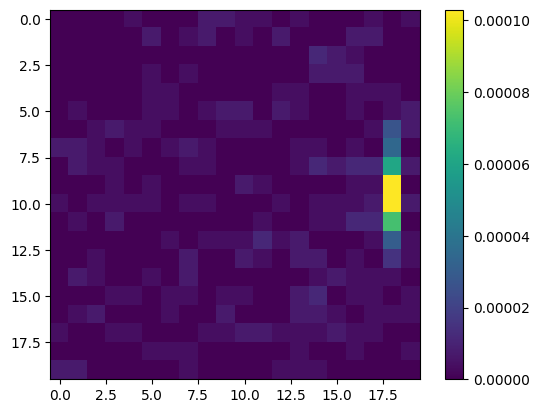

In [3]:
# Setup scene

scene_file = "../scenes/simple_backscattering_reflector/simple_backscattering_reflector.xml"
tx_position = np.array([1.0, 0.0, 0.5])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

# Path loss map used for evaluation
cm_center = np.array([-1., 0, 0.6])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([2., 2.])
cm_cell_size = np.array([0.1, 0.1])
num_samples = int(1e7)
max_depth = 1

scene = mi.load_file(scene_file)
params = mi.traverse(scene)

params['mat-itu_metal.eta_r'] = 1.
params['mat-itu_metal.eta_i'] = 1.0
params['mat-itu_metal.s'] = 0.7
params['mat-itu_metal.lambda'] = 0.7
params.update()

# Define Loss and set trainable variables

def func_obj(x):
    return -1e3*dr.sum(x)

variables =[params['mat-itu_metal.eta_r'],
            params['mat-itu_metal.eta_i'],
            params['mat-itu_metal.s'],
            params['mat-itu_metal.lambda']
           ]
for v in variables:
    dr.enable_grad(v)
    
# Compute gradients with RBP
    
# Reset grads
for v in variables:
    dr.set_grad(v, 0.0)

rbp_tracer = PathlossMapRBPTracer(scene, fc, tx_pattern, tx_slant_angle,
                                  cm_center, cm_orientation, cm_size, cm_cell_size,
                                  num_samples, max_depth)

cm_test,_ = rbp_tracer(tx_position, tx_orientation, func_obj, loop_record=True)
g_test = np.array([dr.grad(v).numpy()[0] for v in variables])
print("RBP Grad: ", g_test)

# Compute gradients with conventional automatic differentiation

# Reset grads
for v in variables:
    dr.set_grad(v, 0.0)

ref_tracer = MapTracer(scene, fc, tx_pattern, tx_slant_angle,
                       cm_center, cm_orientation, cm_size, cm_cell_size,
                       num_samples, max_depth)
cm_ref,_,_,_ = ref_tracer(tx_position, tx_orientation, loop_record=False)
l = func_obj(cm_ref)
dr.backward(l)
g_ref = np.array([dr.grad(v).numpy()[0] for v in variables])
print("Ref. Grad: ", g_ref)

print("Relative Error: ", np.linalg.norm(g_ref-g_test)/np.linalg.norm(g_ref))

cm_ref_db = 10.0*np.log10(cm_ref.numpy()).T
cm_test_db = 10.0*np.log10(cm_test.numpy()).T
ale = np.abs(cm_ref_db - cm_test_db)
plt.figure()
plt.imshow(ale)
plt.colorbar()

# Double Reflector

RBP Grad:  [ 1.8727098e-04 -7.4322161e-04  8.3550689e-04 -6.5419845e-05]
Ref. Grad:  [ 1.8727082e-04 -7.4322108e-04  8.3550601e-04 -6.5419837e-05]
Relative Error:  9.075952e-07


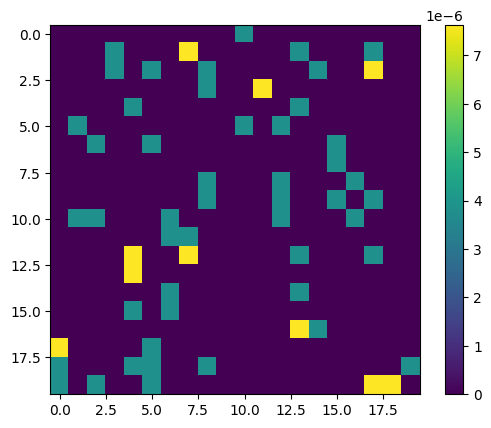

In [4]:
# Setup scene

scene_file = "../scenes/double_backscattering_reflector/double_backscattering_reflector.xml"
tx_position = np.array([-2.0, 0.0, 5.0])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

# Path loss map used for evaluation
cm_center = np.array([2., 0, 0.0])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([2., 2.])
cm_cell_size = np.array([0.1, 0.1])
num_samples = int(1e7)
max_depth = 2

scene = mi.load_file(scene_file)
params = mi.traverse(scene)

params['mat-itu_metal.eta_r'] = 1.1
params['mat-itu_metal.eta_i'] = 1.0
params['mat-itu_metal.s'] = 0.7
params['mat-itu_metal.lambda'] = 0.7
params.update()

# Define Loss and set trainable variables

def func_loss(x):
    return -1e3*dr.sum(x)

variables =[params['mat-itu_metal.eta_r'],
            params['mat-itu_metal.eta_i'],
            params['mat-itu_metal.s'],
            params['mat-itu_metal.lambda']
           ]
for v in variables:
    dr.enable_grad(v)
    
# Compute gradients with RBP
    
# Reset grads
for v in variables:
    dr.set_grad(v, 0.0)

rbp_tracer = PathlossMapRBPTracer(scene, fc, tx_pattern, tx_slant_angle,
                                  cm_center, cm_orientation, cm_size, cm_cell_size,
                                  num_samples, max_depth)

cm_test,_ = rbp_tracer(tx_position, tx_orientation, func_loss, loop_record=True)
g_test = np.array([dr.grad(v).numpy()[0] for v in variables])
print("RBP Grad: ", g_test)

# Compute gradients with vanilla AD

# Reset grads
for v in variables:
    dr.set_grad(v, 0.0)

ref_tracer = MapTracer(scene, fc, tx_pattern, tx_slant_angle,
                       cm_center, cm_orientation, cm_size, cm_cell_size,
                       num_samples, max_depth)
cm_ref,_,_,_ = ref_tracer(tx_position, tx_orientation, loop_record=False)
l = func_loss(cm_ref)
dr.backward(l)
g_ref = np.array([dr.grad(v).numpy()[0] for v in variables])
print("Ref. Grad: ", g_ref)

print("Relative Error: ", np.linalg.norm(g_ref-g_test)/np.linalg.norm(g_ref))

cm_ref_db = 10.0*np.log10(cm_ref.numpy()).T
cm_test_db = 10.0*np.log10(cm_test.numpy()).T
ale = np.abs(cm_ref_db - cm_test_db)
plt.figure()
plt.imshow(ale)
plt.colorbar()

# Floor-wall

RBP Grad:  [-2.3387974e-02 -4.9913162e-04  1.0319018e-01 -9.5513858e-02
 -2.5012636e-01 -5.4635536e-02 -6.8191779e-01]
Ref. Grad:  [-2.3388032e-02 -4.9913180e-04  1.0319018e-01 -9.5513962e-02
 -2.5013155e-01 -5.4637268e-02 -6.8189418e-01]
Relative Error:  3.2644723e-05


/tmp/ipykernel_1863661/1668180513.py:68: RuntimeWarning: divide by zero encountered in log10
  cm_ref_db = 10.0*np.log10(cm_ref.numpy()).T
/tmp/ipykernel_1863661/1668180513.py:69: RuntimeWarning: divide by zero encountered in log10
  cm_test_db = 10.0*np.log10(cm_test.numpy()).T
/tmp/ipykernel_1863661/1668180513.py:70: RuntimeWarning: invalid value encountered in subtract
  ale = np.abs(cm_ref_db - cm_test_db)


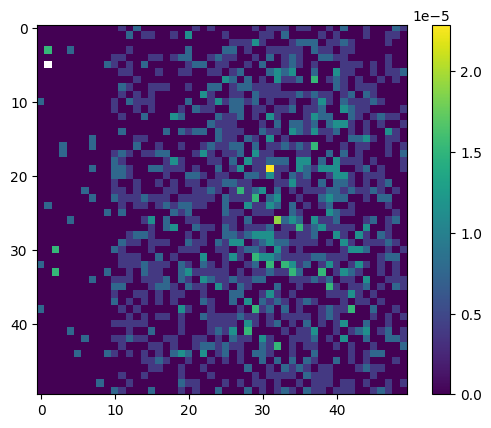

In [5]:
# Setup scene

scene_file = "../scenes/floor_wall_backscattering/floor_wall_backscattering.xml"
tx_position = np.array([2., 0., 2.0])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

cm_center = np.array([0., 0, 0.1])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([5., 5])
cm_cell_size = np.array([0.1, 0.1])
num_samples = int(1e7)
max_depth = 3

scene = mi.load_file(scene_file)
params = mi.traverse(scene)

# Define Loss and set trainable variables

def func_loss(x):
    return -1e3*dr.sum(x)

variables =[
            params['mat-itu_marble.eta_r'],
            params['mat-itu_marble.eta_i'],
            params['mat-itu_marble.s'],
            params['mat-itu_marble.lambda'],
            params['mat-itu_concrete.eta_r'],
            params['mat-itu_concrete.eta_i'],
            params['mat-itu_concrete.s'],
           ]
for v in variables:
    dr.enable_grad(v)
    
# Compute gradients with RBP
    
# Reset grads
for v in variables:
    dr.set_grad(v, 0.0)

rbp_tracer = PathlossMapRBPTracer(scene, fc, tx_pattern, tx_slant_angle,
                                  cm_center, cm_orientation, cm_size, cm_cell_size,
                                  num_samples, max_depth)

cm_test,_ = rbp_tracer(tx_position, tx_orientation, func_loss, loop_record=True)
g_test = np.array([dr.grad(v).numpy()[0] for v in variables])
print("RBP Grad: ", g_test)

# Compute gradients with vanilla AD

# Reset grads
for v in variables:
    dr.set_grad(v, 0.0)

ref_tracer = MapTracer(scene, fc, tx_pattern, tx_slant_angle,
                       cm_center, cm_orientation, cm_size, cm_cell_size,
                       num_samples, max_depth)
cm_ref,_,_,_ = ref_tracer(tx_position, tx_orientation, loop_record=False)
l = func_loss(cm_ref)
dr.backward(l)
g_ref = np.array([dr.grad(v).numpy()[0] for v in variables])
print("Ref. Grad: ", g_ref)

print("Relative Error: ", np.linalg.norm(g_ref-g_test)/np.linalg.norm(g_ref))

cm_ref_db = 10.0*np.log10(cm_ref.numpy()).T
cm_test_db = 10.0*np.log10(cm_test.numpy()).T
ale = np.abs(cm_ref_db - cm_test_db)
plt.figure()
plt.imshow(ale)
plt.colorbar()